Note: this notebook is set up to run with the env.yml containing the name 'polaris_datasets'

## Background
This is part of a release of experimental data determined at AstraZeneca on a set of compounds in the following assays: pKa, lipophilicity (LogD7.4), aqueous solubility, plasma protein binding (human, rat, dog , mouse and guinea pig), intrinsic clearance (human liver microsomes, human and rat hepatocytes). 

## Assay Information:
During a trip through the circulatory system, a drug can bind to many different proteins within the blood plasma. This can affect a drug's efficacy - only the unbound fraction of the drug will exert pharmacological effects. Equilibrium dialysis places a semi-permeable barrier between a drug + plasma sample and a buffer, and after a certain time we measure how much drug is present in the buffer. The membrane lets the drug pass through but drugs bound to proteins are too big to pass across the membrane. Image is from [here](https://www.sciencedirect.com/science/article/abs/pii/S0079646822000029).

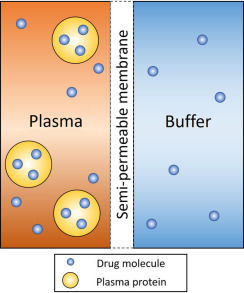

## Description of readout:
- **PPB**: Percent plasma-bound. % bound to plasma by equilibrium dialysis. Compound is incubated with whole human plasma at 37C for >5hrs. Method described in B. Testa et al (Eds.), Pharmacokinetic Profiling in Drug Research: Biological, Physicochemical, and Computational Strategies, Wiley-VCH, Weinheim, 2006, pp.119-141. Experimental range 10% to 99.95% bound.

## Data resource

**Reference**: https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/

**Raw data**: https://www.ebi.ac.uk/chembl/assay_report_card/CHEMBL3301363/

In [1]:
import datamol as dm

from polaris import (
    curation,
    load_dataset,
)
from polaris.curation.viz_utils import (
    visualize_distribution,
    verify_stereoisomers,
    check_undefined_stereocenters,
)
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.utils.types import HubOwner, License
from polaris.hub.client import PolarisHubClient

import tempfile

# For downloading ChEMBL datasets
from chembl_webresource_client.new_client import new_client as client
from tqdm.auto import tqdm
import warnings
import pandas as pd

We can get the dataset directly from ChEMBL (https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301361/ gives the overall experimental data information, and subsequent numbers give data for a specific endpoint). The following map gives information on each:

In [2]:
# chembl_map = {
#     'CHEMBL3301362' : 'Most basic pKa value (pKa B1)', # 261
#     'CHEMBL3301363' : 'Octan-1-ol/water (pH7.4) distribution coefficent', # 4200
#     'CHEMBL3301364' : 'Solubility in pH7.4 buffer', #1763
#     'CHEMBL3301365' : '\% bound to plasma by equilibrium dialysis, human plasma', # PPB # 1614
#     'CHEMBL3301366' : '\% bound to plasma by equilibrium dialysis, rat plasma', # 717
#     'CHEMBL3301367' : '\% bound to plasma by equilibrium dialysis, dog plasma', # 244
#     'CHEMBL3301368' : '\% bound to plasma by equilibrium dialysis, mouse plasma', # 162
#     'CHEMBL3301369' : '\% bound to plasma by equilibrium dialysis, guinea pig plasma', # 91
#     'CHEMBL3301370' : 'Intrinsic clearance measured in human liver microsomes', #1102,
#     'CHEMBL3301371' : 'Intrinsic clearance measured in rat hepatocytes', # 837
#     'CHEMBL3301372' : 'Intrinsic clearance measured in human hepatocytes', # 408
# }

In [3]:
# load data
data = pd.read_parquet('gs://polaris-public/data/raw/AstraZeneca/CHEMBL3301365_raw.parquet')
data

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,14759435,[],CHEMBL3301365,ASTRAZENECA: % bound to plasma by equilibrium ...,A,None,None,BAO_0000179,...,None,ADMET,None,None,None,PPB,%,UO_0000187,None,11.18
1,None,None,14759439,[],CHEMBL3301365,ASTRAZENECA: % bound to plasma by equilibrium ...,A,None,None,BAO_0000179,...,None,ADMET,None,None,None,PPB,%,UO_0000187,None,12.63
2,None,None,14759442,[],CHEMBL3301365,ASTRAZENECA: % bound to plasma by equilibrium ...,A,None,None,BAO_0000179,...,None,ADMET,None,None,None,PPB,%,UO_0000187,None,14.23
3,None,None,14759452,[],CHEMBL3301365,ASTRAZENECA: % bound to plasma by equilibrium ...,A,None,None,BAO_0000179,...,None,ADMET,None,None,None,PPB,%,UO_0000187,None,15.1
4,None,None,14760433,[],CHEMBL3301365,ASTRAZENECA: % bound to plasma by equilibrium ...,A,None,None,BAO_0000179,...,None,ADMET,None,None,None,PPB,%,UO_0000187,None,18.64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,None,None,14767935,[],CHEMBL3301365,ASTRAZENECA: % bound to plasma by equilibrium ...,A,None,None,BAO_0000179,...,None,ADMET,None,None,None,PPB,%,UO_0000187,None,99.94
1610,None,None,14767941,[],CHEMBL3301365,ASTRAZENECA: % bound to plasma by equilibrium ...,A,None,None,BAO_0000179,...,None,ADMET,None,None,None,PPB,%,UO_0000187,None,99.95
1611,None,None,14767943,[],CHEMBL3301365,ASTRAZENECA: % bound to plasma by equilibrium ...,A,None,None,BAO_0000179,...,None,ADMET,None,None,None,PPB,%,UO_0000187,None,99.95
1612,None,None,14767944,[],CHEMBL3301365,ASTRAZENECA: % bound to plasma by equilibrium ...,A,None,None,BAO_0000179,...,None,ADMET,None,None,None,PPB,%,UO_0000187,None,99.95


If we look at the columns in this raw dataframe, we see there are a lot of columns that we don't need. We will focus only on necessary columns below.

In [4]:
print(data.columns)

columns_to_keep = [
    "canonical_smiles",
    "standard_value",
]
data = data[columns_to_keep].copy()

# Convert the readout to numeric values
data["standard_value"] = pd.to_numeric(data["standard_value"])

# Rename columns
data = data.rename(
    columns={
        "canonical_smiles": "SMILES",
        "standard_value": "PPB",
    }
)

data

Index(['action_type', 'activity_comment', 'activity_id', 'activity_properties',
       'assay_chembl_id', 'assay_description', 'assay_type',
       'assay_variant_accession', 'assay_variant_mutation', 'bao_endpoint',
       'bao_format', 'bao_label', 'canonical_smiles', 'data_validity_comment',
       'data_validity_description', 'document_chembl_id', 'document_journal',
       'document_year', 'ligand_efficiency', 'molecule_chembl_id',
       'molecule_pref_name', 'parent_molecule_chembl_id', 'pchembl_value',
       'potential_duplicate', 'qudt_units', 'record_id', 'relation', 'src_id',
       'standard_flag', 'standard_relation', 'standard_text_value',
       'standard_type', 'standard_units', 'standard_upper_value',
       'standard_value', 'target_chembl_id', 'target_organism',
       'target_pref_name', 'target_tax_id', 'text_value', 'toid', 'type',
       'units', 'uo_units', 'upper_value', 'value'],
      dtype='object')


,SMILES,PPB
0,CC(C)(C(=O)c1cccnc1)c1cccnc1,11.18
1,CN(CC(=O)O)NC(=O)C[C@H](N)C[C@@H](O)CN,12.63
2,OC(Cn1cncn1)(Cn1cncn1)c1ccc(F)cc1F,14.23
3,CCN(CC)CCNC(=O)c1ccc(NS(C)(=O)=O)cc1,15.10
4,COc1ccc(C(CN(C)C)C2(O)CCCCC2)cc1,18.64
...,...,...
1609,Cc1cc(Oc2ncc(C(F)(F)F)cc2Cl)ccc1CC1SC(=O)NC1=O,99.94
1610,O=C(O)CCc1nc(-c2ccccc2)c(-c2ccccc2)o1,99.95
1611,CC(C)(O)c1ccccc1CC[C@@H](SCC1(CC(=O)O)CC1)c1cc...,99.95
1612,COc1cc(/C=C2\SC(=O)NC2=O)ccc1Oc1ccc(C#N)cc1C(F...,99.95


In [5]:
# Define data column names
endpoints = [
    'PPB',
]
data_cols = endpoints
mol_col = 'SMILES'

### Run preliminary curation for data inspection

In [6]:
# preliminary curation for data inspection
curator = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=False,
    keep_all_rows = True
)
data_look = curator()

2024-04-02 13:49:23.491 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 46 outliers for data column PPB using zscore. Please revise the data and consider remove the outliers. 
/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


The curation detected 46 outliers in the data. Let's take a look at the distribution.

In [7]:
data_look.head()

,SMILES,PPB,ORIGINAL_PPB,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_PPB,PPB_zscore,PPB_stereo_cliff
0,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,63.47,63.47,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,0007d9df4656b011caf3afc146b6b8fe44a8ea89,b8954faa941a4059fe1fba124a72ed36e95c7760,3,0,3,8,1,False,False,False,-5.513229,NaN
1,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc2nc(NC3CC3)sc12,98.78,98.78,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc2nc(NC3CC3)sc12,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc2nc(NC3CC3)sc12,005d8e75a16c8416c45e430fc967a1a1952a5c4d,78c1d47af1df93c216b82a35bf23ac6ce4f58ff3,1,0,1,2,1,False,False,False,0.577889,NaN
2,CNc1c(C(N)=O)cnc2[nH]c(-c3ccc(OCCN4CCOCC4)cc3)...,78.79,78.79,CNc1c(C(N)=O)cnc2[nH]c(-c3ccc(OCCN4CCOCC4)cc3)...,CNc1c(C(N)=O)cnc2[nH]c(-c3ccc(OCCN4CCOCC4)cc3)...,0080dacfb29829b6ea300706803f50b644023ad4,509f31584227ef3ce34fdd88b95880474de3494b,0,0,0,1,1,False,True,False,-2.870467,NaN
3,O=C(/C=C/c1ccccc1Cl)Nc1ccc2c(c1)C(=O)NC2=O,90.52,90.52,O=C(/C=C/c1ccccc1Cl)Nc1ccc2c(c1)C(=O)NC2=O,O=C(/C=C/c1ccccc1Cl)Nc1ccc2c(c1)C(=O)NC2=O,00a95ca87084604b7cdb18c2367589908889dd62,33442656fd3a00240ebe61802811d4dd29a9a23c,0,0,0,2,1,False,True,False,-0.846995,NaN
4,Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2,85.48,85.48,Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2,Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2,00f93106bb7155995171846abae302368662aabe,e5358bd8ed80cfa6e163d51c3c5a5b86f5c3e051,0,0,0,1,1,False,True,False,-1.716415,NaN


[<Figure size 1600x400 with 2 Axes>]

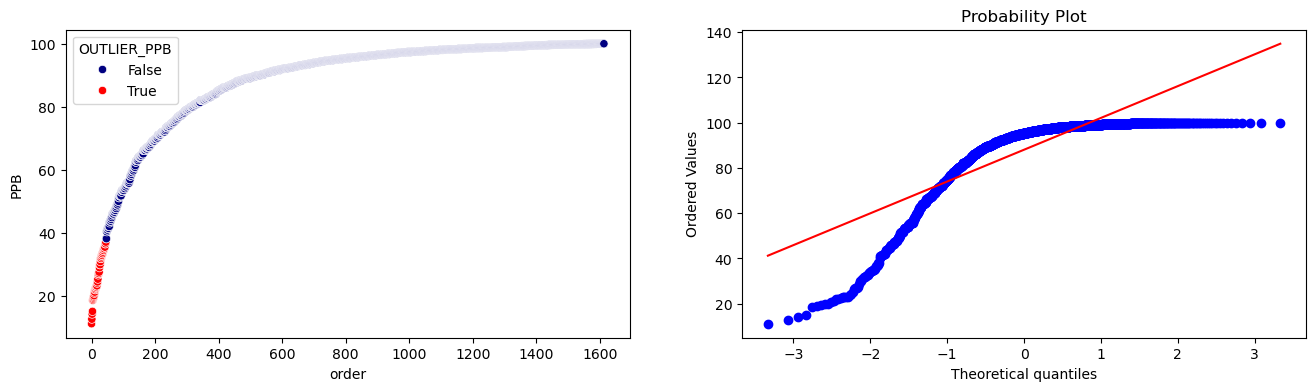

In [8]:
visualize_distribution(dataset=data_look, data_cols=data_cols)

The flagged outliers are likely false outliers as they are located on the end of the data distribution.

### Check activity shift between stereoisomers

In [9]:
data_look[[col for col in data_look.columns if "stereo_cliff" in col]].sum()

PPB_stereo_cliff    16
dtype: object

16 activity shifts were detected in the dataset. Let's identify them for later removal.

In [10]:
data_look[~data_look["PPB_stereo_cliff"].isna()]

,SMILES,PPB,ORIGINAL_PPB,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_PPB,PPB_zscore,PPB_stereo_cliff
123,COc1ccc2ncc(=O)n(CCN3CC[C@@H](NCc4ccc5c(n4)NC(...,71.99,71.99,COc1ccc2ncc(=O)n(CCN3CC[C@@H](NCc4ccc5c(n4)NC(...,COc1ccc2ncc(=O)n(CCN3CC[C@@H](NCc4ccc5c(n4)NC(...,1344825c5e33d428fb51f62dc09a436535482259,dbc909257c73e371088ea8ba021bdbbeb7c2919f,2,0,2,4,1,False,False,False,-4.043494,True
247,CCNC(=O)C[C@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n...,93.10,93.10,CCNC(=O)C[C@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n...,CCNC(=O)C[C@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-n...,26089ff91e01ddc77c6c3f0e9ca9aba68849b2e4,d4ab374b20a7e668543ee2ea529cbcd7c69f2af2,1,0,1,2,1,False,False,False,-0.401934,True
387,O=C(O)C(c1ccccc1)N1CCC(CN2CCC(Oc3ccc(Cl)c(Cl)c...,91.46,91.46,O=C(O)C(c1ccccc1)N1CCC(CN2CCC(Oc3ccc(Cl)c(Cl)c...,O=C(O)C(c1ccccc1)N1CCC(CN2CCC(Oc3ccc(Cl)c(Cl)c...,3ae59035f70f9343c8909405245e09b5a7f48779,79495d62c615b87df7e97e9f42bd6c4ab1ae182b,1,1,0,2,2,True,False,False,-0.684841,True
533,CO[C@H]1CN(CCn2c(=O)ccc3ccc(C#N)cc32)CC[C@@H]1...,84.00,84.00,CO[C@H]1CN(CCn2c(=O)ccc3ccc(C#N)cc32)CC[C@@H]1...,CO[C@H]1CN(CCn2c(=O)ccc3ccc(C#N)cc32)CC[C@@H]1...,5542ee1ed7addd889905f3efaa3f1738dbd84666,8202391a6e93cf080da78a12ed80a1d145fbcde1,2,0,2,4,1,False,False,False,-1.971721,True
579,O=C(O)[C@@H](c1ccccc1)N1CCC(CN2CCC(Oc3ccc(Cl)c...,83.37,83.37,O=C(O)[C@@H](c1ccccc1)N1CCC(CN2CCC(Oc3ccc(Cl)c...,O=C(O)[C@@H](c1ccccc1)N1CCC(CN2CCC(Oc3ccc(Cl)c...,5f08532ce728afde58820fcbb6351732676d7da6,79495d62c615b87df7e97e9f42bd6c4ab1ae182b,1,0,1,2,1,False,False,False,-2.080399,True
696,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...,75.97,75.97,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...,CCNC(=O)C[C@@H]1N=C(c2ccc(Cl)cc2)c2cc(OC)ccc2-...,742383cb3eb9c13c24d291ef5129fdbb3d24ab73,d4ab374b20a7e668543ee2ea529cbcd7c69f2af2,1,0,1,2,1,False,False,False,-3.356928,True
723,COC[C@H](O)Cn1c(=O)cnn(-c2ccc(Cl)c(C(=O)NCC3(O...,58.55,58.55,COC[C@H](O)Cn1c(=O)cnn(-c2ccc(Cl)c(C(=O)NCC3(O...,COC[C@H](O)Cn1c(=O)cnn(-c2ccc(Cl)c(C(=O)NCC3(O...,77fba64ee7fe6fe7b341f746449a64c4b8379fee,a4bbc8bff9908de7678f70c502061004620012d6,1,0,1,2,1,False,False,False,-6.361949,True
725,COc1ccc(C2Sc3ccccc3N(CCN(C)C)C(=O)C2OC(C)=O)cc1,35.46,35.46,COc1ccc(C2Sc3ccccc3N(CCN(C)C)C(=O)C2OC(C)=O)cc1,COc1ccc(C2Sc3ccccc3N(CCN(C)C)C(=O)C2OC(C)=O)cc1,781d03654f725ff204485c99ada304bb16a4538b,30c92b69904aba6e14e85806852b189fb9813d82,2,2,0,4,4,True,False,True,-10.345067,True
749,COC[C@@H](O)Cn1c(=O)cnn(-c2ccc(Cl)c(C(=O)NCC3(...,41.45,41.45,COC[C@@H](O)Cn1c(=O)cnn(-c2ccc(Cl)c(C(=O)NCC3(...,COC[C@@H](O)Cn1c(=O)cnn(-c2ccc(Cl)c(C(=O)NCC3(...,7b3e0d77039d6461175f17cefb9bd1e4c152c2f1,a4bbc8bff9908de7678f70c502061004620012d6,1,0,1,2,1,False,False,False,-9.311768,True
881,COc1ccc2ncc(=O)n(CCN3CC[C@H](NCc4ccc5c(n4)NC(=...,86.32,86.32,COc1ccc2ncc(=O)n(CCN3CC[C@H](NCc4ccc5c(n4)NC(=...,COc1ccc2ncc(=O)n(CCN3CC[C@H](NCc4ccc5c(n4)NC(=...,8d0036db2edbe9718d1eed67b08e95db157cd72e,0389e8cf386271509b5650f26dbe4197101e77c9,2,0,2,4,1,False,False,False,-1.571512,True


### Check the molecules with undefined stereocenters

Note: feature currently not working

In [11]:
# data_look['mol'] = data_look['smiles'].apply(dm.to_mol) # Convert smiles to RDKit Mol object
# fig, _ = check_undefined_stereocenters(dataset=data_look)
# fig

In [12]:
# _[data_cols].boxplot(rot=90)

### Re-run curation, removing molecules as needed

In [13]:
### Re-run the curation steps, this time removing molecules with undefined stereoisomers and removing duplicates
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    # remove molecules that have undefined stereocenters and also show activity shift to the stereoisomers
    mask_stereo_undefined_mols=True,
    # remove all the molecule rows including the duplicates
    keep_all_rows=False,
)

print(f'size before curation: {len(data)}')
data_curated = curator_with_stereo()
print(f'size after curation: {len(data_curated)}')

size before curation: 1614


2024-04-02 13:49:26.948 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 46 outliers for data column PPB using zscore. Please revise the data and consider remove the outliers. 


size after curation: 1614


/Users/shawn.whitfield/Documents/ValenceLabs/Polaris/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True


In [14]:
# Drop molecules with stereo activity cliff
data_curated = data_curated.drop(data_curated[~data_curated["PPB_stereo_cliff"].isna()].index)
data_curated

,SMILES,PPB,ORIGINAL_PPB,ORIGINAL_SMILES,smiles,molhash_id,molhash_id_no_stereo,num_stereo_center,num_undefined_stereo_center,num_defined_stereo_center,num_stereoisomers,num_undefined_stereoisomers,undefined_E_D,undefined_E/Z,OUTLIER_PPB,PPB_zscore,PPB_stereo_cliff
0,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,63.47,63.47,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,CN[C@@H](C)C(=O)N[C@H](C(=O)N[C@H]1CCCN(Cc2ccc...,0007d9df4656b011caf3afc146b6b8fe44a8ea89,b8954faa941a4059fe1fba124a72ed36e95c7760,3,0,3,8,1,False,False,False,-5.513229,NaN
1,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc2nc(NC3CC3)sc12,98.78,98.78,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc2nc(NC3CC3)sc12,C[C@H](CO)Nc1nc(SCc2cccc(F)c2F)nc2nc(NC3CC3)sc12,005d8e75a16c8416c45e430fc967a1a1952a5c4d,78c1d47af1df93c216b82a35bf23ac6ce4f58ff3,1,0,1,2,1,False,False,False,0.577889,NaN
2,CNc1c(C(N)=O)cnc2[nH]c(-c3ccc(OCCN4CCOCC4)cc3)...,78.79,78.79,CNc1c(C(N)=O)cnc2[nH]c(-c3ccc(OCCN4CCOCC4)cc3)...,CNc1c(C(N)=O)cnc2[nH]c(-c3ccc(OCCN4CCOCC4)cc3)...,0080dacfb29829b6ea300706803f50b644023ad4,509f31584227ef3ce34fdd88b95880474de3494b,0,0,0,1,1,False,True,False,-2.870467,NaN
3,O=C(/C=C/c1ccccc1Cl)Nc1ccc2c(c1)C(=O)NC2=O,90.52,90.52,O=C(/C=C/c1ccccc1Cl)Nc1ccc2c(c1)C(=O)NC2=O,O=C(/C=C/c1ccccc1Cl)Nc1ccc2c(c1)C(=O)NC2=O,00a95ca87084604b7cdb18c2367589908889dd62,33442656fd3a00240ebe61802811d4dd29a9a23c,0,0,0,2,1,False,True,False,-0.846995,NaN
4,Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2,85.48,85.48,Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2,Cc1nnc2n1-c1ccc(Cl)cc1C(c1ccccc1Cl)=NC2,00f93106bb7155995171846abae302368662aabe,e5358bd8ed80cfa6e163d51c3c5a5b86f5c3e051,0,0,0,1,1,False,True,False,-1.716415,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1609,NC(=O)c1cnc(N[C@H]2CCCNC2)c2cc(-c3ccc(F)c(Cl)c...,99.61,99.61,NC(=O)c1cnc(N[C@H]2CCCNC2)c2cc(-c3ccc(F)c(Cl)c...,NC(=O)c1cnc(N[C@H]2CCCNC2)c2cc(-c3ccc(F)c(Cl)c...,fee3c84f1fc22239b47919e4599146408a4306ce,c8a95426c47f3be2746ae3ef7b5b0b158e223e4d,1,0,1,2,1,False,False,False,0.721067,NaN
1610,CCCn1c(=O)[nH]c(=O)c2nc[nH]c21,67.12,67.12,CCCn1c(=O)[nH]c(=O)c2nc[nH]c21,CCCn1c(=O)[nH]c(=O)c2nc[nH]c21,fee9d3ea710c6e1570389bc4149a26909948e487,68fe5ade538f1c881a5ce0d3d6d070ae788ba91c,0,0,0,1,1,False,True,False,-4.883589,NaN
1611,Cc1nc(CSc2nc(N[C@H](C)CO)c3sc(=O)[nH]c3n2)cs1,99.14,99.14,Cc1nc(CSc2nc(N[C@H](C)CO)c3sc(=O)[nH]c3n2)cs1,Cc1nc(CSc2nc(N[C@H](C)CO)c3sc(=O)[nH]c3n2)cs1,ff22471a9e7c49e6c867d676ab3a50cd6af6cfa7,326ff9ff8fb86ae04a53294969307e486aacf205,1,0,1,2,1,False,False,False,0.639990,NaN
1612,CN(Cc1cccc2ccccc12)c1cc(N2CCOCC2)nc(=O)[nH]1,94.32,94.32,CN(Cc1cccc2ccccc12)c1cc(N2CCOCC2)nc(=O)[nH]1,CN(Cc1cccc2ccccc12)c1cc(N2CCOCC2)nc(=O)[nH]1,ffabf228a21351664bb43410bd42bccc46f5c0d5,6a1f7882e24337651291b246a60ee6947ff579ce,0,0,0,1,1,False,True,False,-0.191479,NaN


In [15]:
# Additional meta-data on the column level
annotations = {
    "smiles": ColumnAnnotation(description="Molecule SMILES string", modality="molecule"),

    'PPB': ColumnAnnotation(description="Percent bound to whole human plasma by equilibrium dialysis.",
                            user_attributes={"unit": "percent",
                                             "organism": 'human'},)
}

In [16]:
dataset = Dataset(
    # The table is the core data-structure required to construct a dataset
    table=data_curated,
    # Additional meta-data on the dataset level.
    name="AstraZeneca_PPB",
    description="Percent of compound bound to whole human plasma (PPB) experiment data released by AstraZeneca",
    source="https://www.ebi.ac.uk/chembl/document_report_card/CHEMBL3301365/",
    annotations=annotations,
    tags=["ADME"],
    owner=HubOwner(user_id="Shawn Whitfield", slug="swhitfield"),
    license=License(id="MIT"),
    user_attributes={"year": "2016"},
)

In [17]:
# Make a temporary directory to save the dataset
temp_dir = tempfile.TemporaryDirectory().name

save_dir = dm.fs.join(temp_dir, "dataset")

path = dataset.to_json(save_dir)

# Look at the save destination
fs = dm.fs.get_mapper(save_dir).fs
fs.ls(save_dir)

/Users/shawn.whitfield/miniconda3/envs/polaris_datasets/lib/python3.12/site-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `url` but got `str` - serialized value may not be as expected
  Expected `url` but got `str` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


['/var/folders/kq/q3sv3jmd5ys443j8rfrgmrxm0000gq/T/tmpa98c5uyj/dataset/table.parquet',
 '/var/folders/kq/q3sv3jmd5ys443j8rfrgmrxm0000gq/T/tmpa98c5uyj/dataset/dataset.json']

In [18]:
# data_curated.to_parquet(f'./data/CHEMBL3301365_curated.parquet') # Save just in case
data_curated.to_parquet(f"gs://polaris-public/data/raw/AstraZeneca/CHEMBL3301365_curated.parquet")

In [19]:
# Load dataset through json file given
# dataset = load_dataset(path)

In [20]:
# NOTE: Commented out to not flood the DB
# with PolarisHubClient() as client:
#     client.upload_dataset(dataset=dataset)